In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LassoCV
from sklearn.tree import plot_tree
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.formula.api as sm
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor  
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from dmba import regressionSummary, exhaustive_search, backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score, classificationSummary
from dmba import plotDecisionTree, gainsChart, liftChart
from pandas.plotting import parallel_coordinates
from pandas.plotting import scatter_matrix
import graphviz  

%matplotlib inline

In [2]:
# Load the datasets
d1 = pd.read_csv("student-mat.csv", sep=",")  # Change to "," if ";" doesn't work
d2 = pd.read_csv("student-por.csv", sep=",")

In [3]:
print(d1.head())
print(d2.head())

print("Columns in d1:", d1.columns)
print("Columns in d2:", d2.columns)

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     G

In [4]:
# Common columns for merging
common_columns = [
    "school", "sex", "age", "address", "famsize", "Pstatus",
    "Medu", "Fedu", "Mjob", "Fjob", "reason", "guardian",
    "nursery", "internet"
]

# Perform the merge
d3 = pd.merge(d1, d2, on=common_columns, suffixes=('_mat', '_por'))

# List of relevant variables for averaging
columns_to_average = {
    "Dalc": ["Dalc_mat", "Dalc_por"],
    "Walc": ["Walc_mat", "Walc_por"],
    "studytime": ["studytime_mat", "studytime_por"],
    "G1": ["G1_mat", "G1_por"],
    "G2": ["G2_mat", "G2_por"],
    "G3": ["G3_mat", "G3_por"]
}

# Compute the averages and create new columns
for col, (mat_col, por_col) in columns_to_average.items():
    d3[col] = d3[[mat_col, por_col]].mean(axis=1)

# Keep only relevant columns
final_columns = common_columns + list(columns_to_average.keys())
d3_cleaned = d3[final_columns]

# Display the cleaned dataset
print(d3_cleaned.head())
print(f"Final dataset shape: {d3_cleaned.shape}")

  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

   reason guardian nursery internet  Dalc  Walc  studytime    G1    G2    G3  
0  course   mother     yes       no   1.0   1.0        2.0   2.5   8.5   8.5  
1  course   father      no      yes   1.0   1.0        2.0   7.0   8.0   8.5  
2   other   mother     yes      yes   2.0   3.0        2.0   9.5  10.5  11.0  
3    home   mother     yes      yes   1.0   1.0        3.0  14.5  14.0  14.5  
4    home   father     yes       no   1.0   2.0        2.0   8.5  11.5  11.5  
Final dataset shape: (376, 20)


In [5]:
print(d3_cleaned.info())
print(d3_cleaned.head())
print(d3_cleaned.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   school     376 non-null    object 
 1   sex        376 non-null    object 
 2   age        376 non-null    int64  
 3   address    376 non-null    object 
 4   famsize    376 non-null    object 
 5   Pstatus    376 non-null    object 
 6   Medu       376 non-null    int64  
 7   Fedu       376 non-null    int64  
 8   Mjob       376 non-null    object 
 9   Fjob       376 non-null    object 
 10  reason     376 non-null    object 
 11  guardian   376 non-null    object 
 12  nursery    376 non-null    object 
 13  internet   376 non-null    object 
 14  Dalc       376 non-null    float64
 15  Walc       376 non-null    float64
 16  studytime  376 non-null    float64
 17  G1         376 non-null    float64
 18  G2         376 non-null    float64
 19  G3         376 non-null    float64
dtypes: float64

In [6]:
# Check the shape of the final dataset and confirm no data loss
print(f"Number of rows: {d3_cleaned.shape[0]}")
print(f"Number of columns: {d3_cleaned.shape[1]}")

Number of rows: 376
Number of columns: 20


In [7]:
# Summary statistics for numerical columns
print(d3_cleaned.describe())

# Value counts for categorical columns
categorical_columns = ["school", "sex", "address", "famsize", "Pstatus", "reason", "guardian", "nursery", "internet"]
for col in categorical_columns:
    print(f"{col} Value Counts:\n{d3[col].value_counts()}\n")

              age        Medu        Fedu        Dalc        Walc   studytime  \
count  376.000000  376.000000  376.000000  376.000000  376.000000  376.000000   
mean    16.585106    2.792553    2.547872    1.477394    2.289894    2.039894   
std      1.176749    1.087896    1.094396    0.890779    1.284681    0.845224   
min     15.000000    0.000000    0.000000    1.000000    1.000000    1.000000   
25%     16.000000    2.000000    2.000000    1.000000    1.000000    1.000000   
50%     17.000000    3.000000    3.000000    1.000000    2.000000    2.000000   
75%     17.000000    4.000000    4.000000    2.000000    3.000000    2.000000   
max     22.000000    4.000000    4.000000    5.000000    5.000000    4.000000   

               G1          G2          G3  
count  376.000000  376.000000  376.000000  
mean    11.482713   11.466755   11.462766  
std      2.638251    2.821742    3.311990  
min      2.500000    3.500000    0.000000  
25%      9.875000    9.500000    9.500000  
50%   

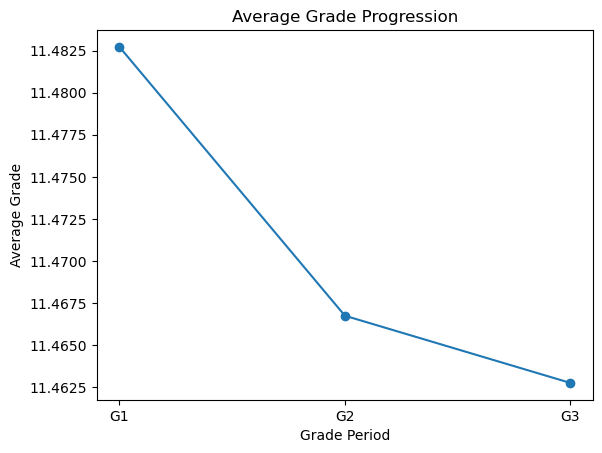

In [8]:
# Line plot to show progression of grades
grades = d3_cleaned[['G1', 'G2', 'G3']].mean()
plt.plot(['G1', 'G2', 'G3'], grades, marker='o')
plt.title("Average Grade Progression")
plt.xlabel("Grade Period")
plt.ylabel("Average Grade")
plt.show()

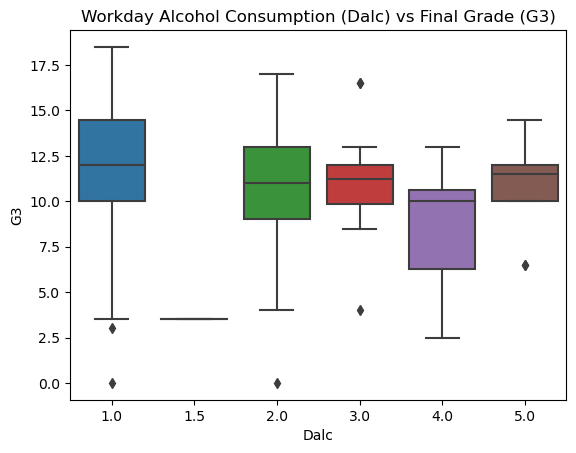

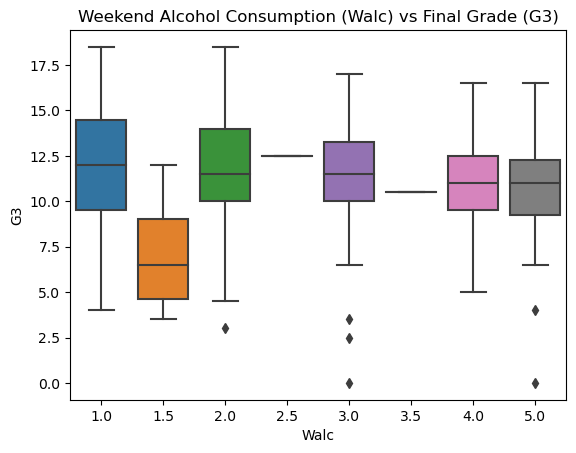

In [9]:
# Boxplot: Workday alcohol consumption and grades
sns.boxplot(x='Dalc', y='G3', data= d3_cleaned)
plt.title("Workday Alcohol Consumption (Dalc) vs Final Grade (G3)")
plt.show()

# Boxplot: Weekend alcohol consumption and grades
sns.boxplot(x='Walc', y='G3', data= d3_cleaned)
plt.title("Weekend Alcohol Consumption (Walc) vs Final Grade (G3)")
plt.show()

/var/folders/9s/szzjlq6j5sv3fq1krv3r8sc80000gn/T/ipykernel_8576/3475303884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3_cleaned['Total_Alcohol'] = d3_cleaned['Dalc'] + d3_cleaned['Walc']


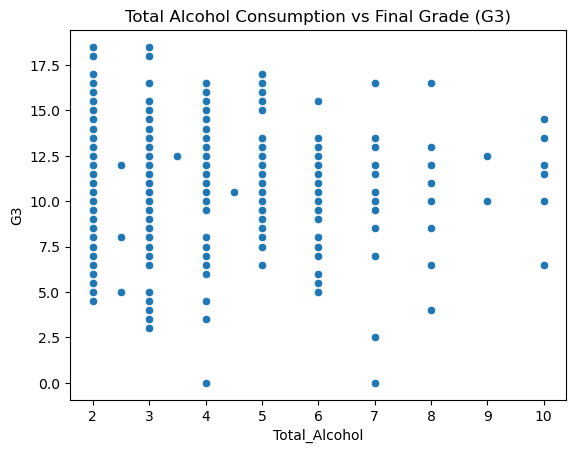

In [10]:
# Add a combined alcohol consumption variable
d3_cleaned['Total_Alcohol'] = d3_cleaned['Dalc'] + d3_cleaned['Walc']

# Scatterplot for Total Alcohol Consumption vs Grades
sns.scatterplot(x='Total_Alcohol', y='G3', data=d3_cleaned)
plt.title("Total Alcohol Consumption vs Final Grade (G3)")
plt.show()

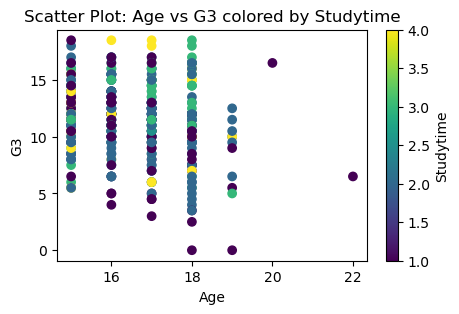

In [11]:
# Scatter plot with coloring based on studytime
plt.figure(figsize=(5, 3))
plt.scatter(d3_cleaned['age'], d3_cleaned['G3'], c=d3_cleaned['studytime'], cmap='viridis')
plt.colorbar(label='Studytime')
plt.xlabel('Age')
plt.ylabel('G3')
plt.title('Scatter Plot: Age vs G3 colored by Studytime')
plt.show()

/var/folders/9s/szzjlq6j5sv3fq1krv3r8sc80000gn/T/ipykernel_8576/2897992875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3_cleaned['Alcohol_Category'] = pd.cut(d3_cleaned['Total_Alcohol'], bins=[0, 4, 8, 10], labels=['Low', 'Medium', 'High'])


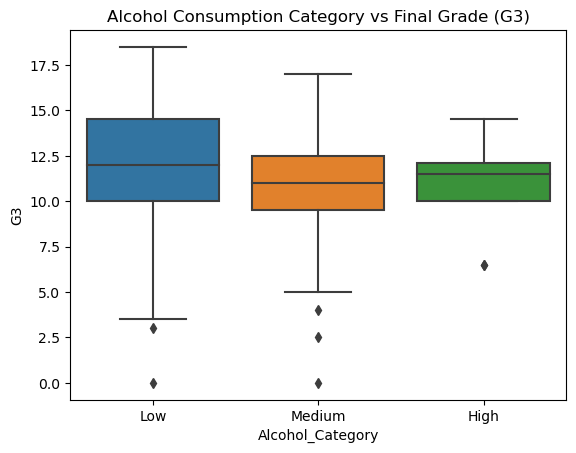

In [12]:
# Categorize students based on total alcohol consumption
d3_cleaned['Alcohol_Category'] = pd.cut(d3_cleaned['Total_Alcohol'], bins=[0, 4, 8, 10], labels=['Low', 'Medium', 'High'])

# Boxplot: Alcohol category and grades
sns.boxplot(x='Alcohol_Category', y='G3', data=d3_cleaned)
plt.title("Alcohol Consumption Category vs Final Grade (G3)")
plt.show()

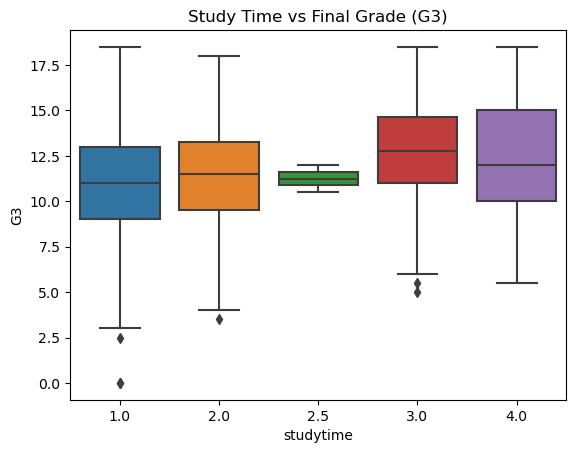

In [13]:
sns.boxplot(x='studytime', y='G3', data=d3_cleaned)
plt.title("Study Time vs Final Grade (G3)")
plt.show()

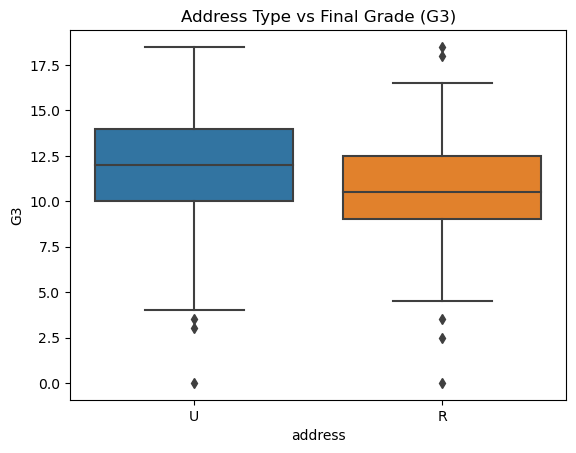

In [14]:
sns.boxplot(x='address', y='G3', data=d3_cleaned)
plt.title("Address Type vs Final Grade (G3)")
plt.show()

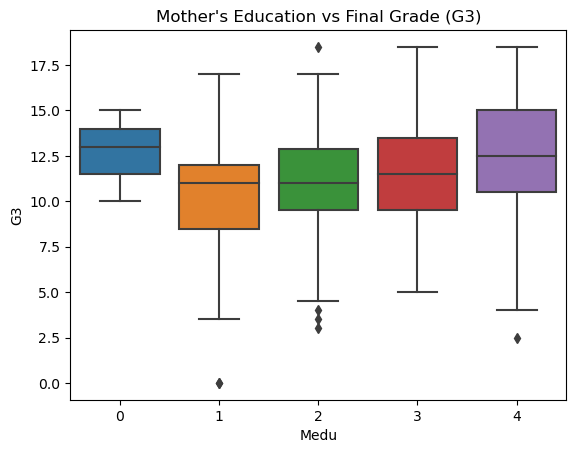

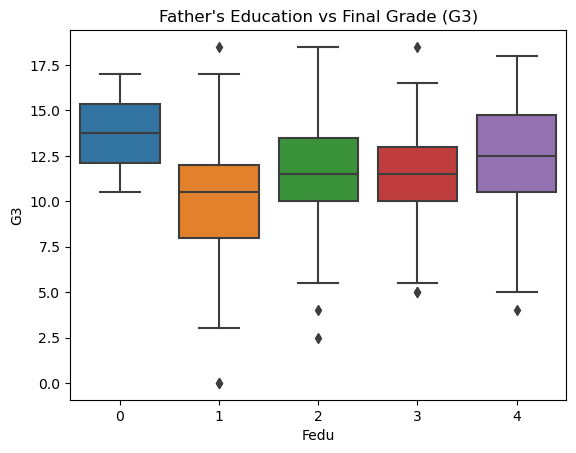

In [15]:
sns.boxplot(x='Medu', y='G3', data=d3_cleaned)
plt.title("Mother's Education vs Final Grade (G3)")
plt.show()

sns.boxplot(x='Fedu', y='G3', data=d3_cleaned)
plt.title("Father's Education vs Final Grade (G3)")
plt.show()

In [16]:
# Compute the correlation matrix for numeric columns
numeric_data = d3_cleaned.select_dtypes(include=[np.number])
corr = numeric_data.corr()
corr

,age,Medu,Fedu,Dalc,Walc,studytime,G1,G2,G3,Total_Alcohol
age,1.000000,-0.125736,-0.133624,0.129676,0.149449,-0.008785,-0.125147,-0.135471,-0.163740,0.155004
Medu,-0.125736,1.000000,0.644463,0.041928,-0.014097,0.056875,0.249606,0.247495,0.247265,0.009697
Fedu,-0.133624,0.644463,1.000000,0.016842,0.002431,0.003696,0.218023,0.207548,0.198398,0.009137
Dalc,0.129676,0.041928,0.016842,1.000000,0.651805,-0.188286,-0.166685,-0.146972,-0.147618,0.871100
Walc,0.149449,-0.014097,0.002431,0.651805,1.000000,-0.247668,-0.155678,-0.139862,-0.122020,0.940235
studytime,-0.008785,0.056875,0.003696,-0.188286,-0.247668,1.000000,0.220647,0.202654,0.181763,-0.244925
G1,-0.125147,0.249606,0.218023,-0.166685,-0.155678,0.220647,1.000000,0.906010,0.872375,-0.175656
G2,-0.135471,0.247495,0.207548,-0.146972,-0.139862,0.202654,0.906010,1.000000,0.933571,-0.156562
G3,-0.163740,0.247265,0.198398,-0.147618,-0.122020,0.181763,0.872375,0.933571,1.000000,-0.145299
Total_Alcohol,0.155004,0.009697,0.009137,0.871100,0.940235,-0.244925,-0.175656,-0.156562,-0.145299,1.000000


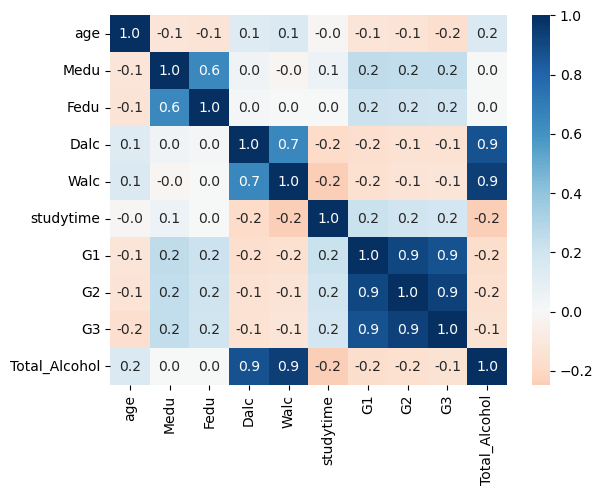

In [17]:
# Plot a heatmap of the correlation matrix
sns.heatmap(corr, annot=True, fmt=".1f", cmap="RdBu", center=0)
plt.show()

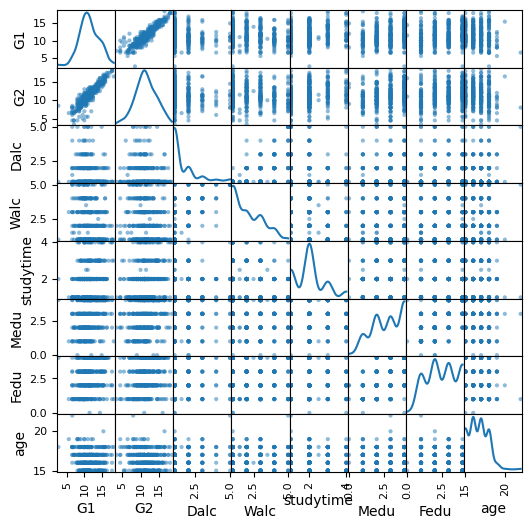

In [18]:
# Scatter plot matrix for selected numeric features
scatter_matrix(d3_cleaned[['G1', 'G2', 'Dalc', 'Walc', 'studytime', 'Medu', 'Fedu', 'age']], figsize=(6, 6), diagonal='kde')
plt.show()


In [19]:
# Define predictors and target
predictors = ['G1', 'G2', 'Dalc', 'Walc', 'studytime', 'Medu', 'Fedu', 'age']
X = d3_cleaned[predictors]
y = d3_cleaned['G3']

# Split into training and testing sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# Print the shape of train and validation sets
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_valid.shape)

Training data shape: (300, 8)
Validation data shape: (76, 8)


In [21]:
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [22]:
# Predictions for training and validation sets
train_pred = model.predict(X_train)
valid_pred = model.predict(X_valid)

In [23]:
# Results DataFrame
train_results = pd.DataFrame({'actual': y_train, 'predicted': train_pred, 'residual': y_train - train_pred})
train_results.head()

,actual,predicted,residual
109,9.0,8.564370,0.435630
219,15.5,14.723430,0.776570
350,9.5,9.166008,0.333992
195,17.0,17.037793,-0.037793
75,10.5,10.133104,0.366896


In [24]:
valid_results = pd.DataFrame({'actual': y_valid, 'predicted': valid_pred, 'residual': y_valid - valid_pred})
valid_results.head()

,actual,predicted,residual
290,16.5,17.075557,-0.575557
357,7.0,5.648736,1.351264
261,11.0,10.663551,0.336449
157,11.5,10.178655,1.321345
145,12.0,12.522580,-0.522580


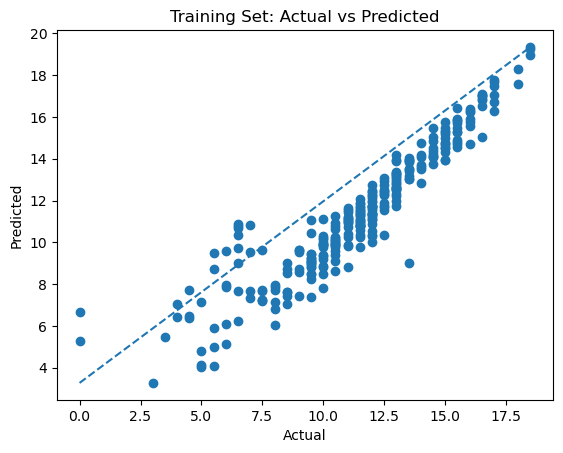

In [25]:
# Plotting Actual vs Predicted for Training Set
plt.figure()
plt.scatter(train_results['actual'], train_results['predicted'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Set: Actual vs Predicted')
plt.plot([min(train_results['actual']), max(train_results['actual'])], 
         [min(train_results['predicted']), max(train_results['predicted'])], '--')
plt.show()

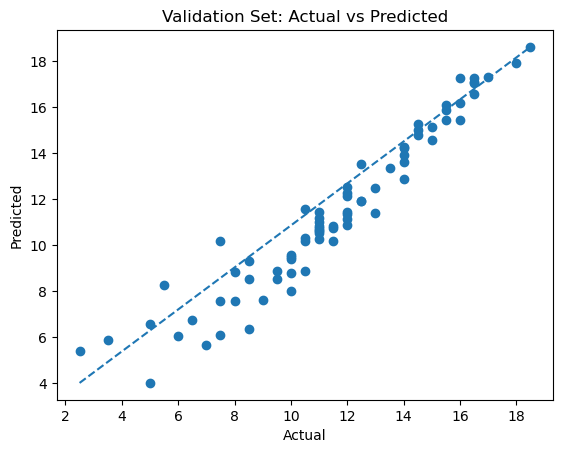

In [26]:
# Plotting Actual vs Predicted for Validation Set
plt.figure()
plt.scatter(valid_results['actual'], valid_results['predicted'])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Validation Set: Actual vs Predicted')
plt.plot([min(valid_results['actual']), max(valid_results['actual'])], 
         [min(valid_results['predicted']), max(valid_results['predicted'])], '--')
plt.show()

In [27]:
# Evaluation Metrics
train_r2 = r2_score(train_results['actual'], train_results['predicted'])
valid_r2 = r2_score(valid_results['actual'], valid_results['predicted'])
print(f'Training set R2: {train_r2}')
print(f'Validation set R2: {valid_r2}')

Training set R2: 0.865482320487323
Validation set R2: 0.9173285716138717


In [28]:
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(train_results['actual'], train_results['predicted'])
valid_mae = mean_absolute_error(valid_results['actual'], valid_results['predicted'])
print(f'Training set MAE: {train_mae}')
print(f'Validation set MAE: {valid_mae}')

Training set MAE: 0.7718227176755825
Validation set MAE: 0.7322267676949804


In [29]:
# Display coefficients and feature names
feature_importance = pd.DataFrame({
    'Feature': predictors,
    'Coefficient': model.coef_
})
print(feature_importance)

     Feature  Coefficient
0         G1     0.245966
1         G2     0.889968
2       Dalc    -0.030382
3       Walc     0.075050
4  studytime    -0.015213
5       Medu     0.136266
6       Fedu    -0.112859
7        age    -0.129127


In [30]:
# Multiple Linear Regression with StatsModels
formula = 'G3 ~ G1 + G2 + Dalc + Walc + studytime + Medu + Fedu + age'
student_lm = sm.ols(formula=formula, data=d3).fit()
print(student_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     329.7
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          1.96e-162
Time:                        17:08:53   Log-Likelihood:                -588.00
No. Observations:                 376   AIC:                             1194.
Df Residuals:                     367   BIC:                             1229.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4075      0.959      0.425      0.6

In [31]:
# 8. Exhaustive Search for Feature Selection
# Corrected train_model function
def train_model(variables):
    model = LinearRegression()
    model.fit(X_train[variables], y_train)  
    return model


def score_model(model, variables):
    y_pred = model.predict(X_train[variables])
    return -adjusted_r2_score(y_train, y_pred, model)

# Perform exhaustive search to find the best feature combination
allVariables = X_train.columns
results = exhaustive_search(allVariables, train_model, score_model)

In [32]:
# Store results and calculate AIC for each set of variables
data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(y_train, model.predict(X_train[variables]), model)
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)

In [33]:
# Print the results in a readable format
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))

   n     r2adj         AIC   Dalc   Fedu     G1    G2   Medu   Walc    age  \
0  1  0.855392  987.735353  False  False  False  True  False  False  False   
1  2  0.860795  977.304796  False  False   True  True  False  False  False   
2  3  0.862222  975.200518  False  False   True  True  False  False   True   
3  4  0.862390  975.820613  False  False   True  True  False   True   True   
4  5  0.862505  976.550551  False   True   True  True   True  False   True   
5  6  0.862679  977.147709  False   True   True  True   True   True   True   
6  7  0.862244  979.072285   True   True   True  True   True   True   True   
7  8  0.861784  981.042038   True   True   True  True   True   True   True   

   studytime  
0      False  
1      False  
2      False  
3      False  
4      False  
5      False  
6      False  
7       True  


In [34]:
# 8.1 Backward Elimination
bestBE_model, best_variables = backward_elimination(X_train.columns, train_model, score_model, verbose=True)

# Print the best variables selected by Backward Elimination
print("Best variables from Backward Elimination:", best_variables)

# Evaluate the model on the validation set
regressionSummary(y_valid, bestBE_model.predict(X_valid[best_variables]))


Variables: G1, G2, Dalc, Walc, studytime, Medu, Fedu, age
Start: score=-0.86
Step: score=-0.86, remove studytime
Step: score=-0.86, remove Dalc
Step: score=-0.86, remove None
Best variables from Backward Elimination: ['G1', 'G2', 'Walc', 'Medu', 'Fedu', 'age']

Regression statistics

                      Mean Error (ME) : 0.0781
       Root Mean Squared Error (RMSE) : 0.9946
            Mean Absolute Error (MAE) : 0.7372
          Mean Percentage Error (MPE) : -1.2865
Mean Absolute Percentage Error (MAPE) : 9.4242


In [35]:
# 8.2 Forward Selection
# Define train model for forward selection
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X_train[variables], y_train)  # Using X_train and y_train as per your structure
    return model

# Define score model for forward selection
def score_model(model, variables):
    if len(variables) == 0:
        # Return AIC score for the baseline model (mean of y_train)
        return AIC_score(y_train, [y_train.mean()] * len(y_train), model, df=1)
    # Return AIC score for the model with selected variables
    return AIC_score(y_train, model.predict(X_train[variables]), model)

# Perform forward selection for feature selection
bestFS_model, best_variables = forward_selection(X_train.columns, train_model, score_model, verbose=True)

# Print the best variables selected by Forward Selection
print("Best variables from Forward Selection:", best_variables)

# Evaluate the model on the validation set using the best variables
regressionSummary(y_valid, bestFS_model.predict(X_valid[best_variables]))



Variables: G1, G2, Dalc, Walc, studytime, Medu, Fedu, age
Start: score=1566.86, constant
Step: score=987.74, add G2
Step: score=977.30, add G1
Step: score=975.20, add age
Step: score=975.20, add None
Best variables from Forward Selection: ['G2', 'G1', 'age']

Regression statistics

                      Mean Error (ME) : 0.0906
       Root Mean Squared Error (RMSE) : 0.9614
            Mean Absolute Error (MAE) : 0.6990
          Mean Percentage Error (MPE) : -1.0423
Mean Absolute Percentage Error (MAPE) : 8.9102


In [36]:
# 8.3 Stepwise Selection
bestSW_model, best_variables = stepwise_selection(X_train.columns, train_model, score_model, verbose=True)

# Print the best variables selected by Stepwise Selection
print("Best variables from Stepwise Selection:", best_variables)

# Evaluate the model on the validation set using the best variables
regressionSummary(y_valid, bestSW_model.predict(X_valid[best_variables]))


Variables: G1, G2, Dalc, Walc, studytime, Medu, Fedu, age
Start: score=1566.86, constant
Step: score=987.74, add G2
Step: score=977.30, add G1
Step: score=975.20, add age
Step: score=975.20, unchanged None
Best variables from Stepwise Selection: ['G2', 'G1', 'age']

Regression statistics

                      Mean Error (ME) : 0.0906
       Root Mean Squared Error (RMSE) : 0.9614
            Mean Absolute Error (MAE) : 0.6990
          Mean Percentage Error (MPE) : -1.0423
Mean Absolute Percentage Error (MAPE) : 8.9102


In [37]:
# 9. k-Nearest Neighbors (kNN)

# 9.1: Define the features and target
features = ['G1', 'G2', 'Dalc', 'Walc', 'studytime', 'Medu', 'Fedu', 'age']

# 9.2: Use StandardScaler to normalize features for both train and validation data
scaler = preprocessing.StandardScaler()

In [38]:
# Fit the scaler on the training data and transform both train and validation data
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(X_train[features])  
valid_data_scaled = scaler.transform(X_valid[features])      


In [39]:
# Convert the scaled data back to DataFrame for compatibility with further processing
trainNorm = pd.DataFrame(train_data_scaled, columns=[f'z{col}' for col in features], index=X_train.index)
validNorm = pd.DataFrame(valid_data_scaled, columns=[f'z{col}' for col in features], index=X_valid.index)

In [40]:
# 9.3: Initialize kNN Regressor and train the model
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(trainNorm, y_train)

# Predictions for the validation set
knn_predictions = knn.predict(validNorm)

In [41]:
# 9.4: Evaluate kNN Performance
knn_r2 = r2_score(y_valid, knn_predictions)  # Use y_valid instead of valid_y
knn_mae = mean_absolute_error(y_valid, knn_predictions)  # Use y_valid instead of valid_y

print(f'kNN Validation R2: {knn_r2}')
print(f'kNN Validation MAE: {knn_mae}')



kNN Validation R2: 0.7534455233826911
kNN Validation MAE: 1.1359649122807014


In [42]:
# 9.5: Model Comparison (kNN and Linear Regression)
print(f'Linear Regression Validation R2: {valid_r2}')
print(f'Linear Regression Validation MAE: {valid_mae}')
print(f'kNN Validation R2: {knn_r2}')
print(f'kNN Validation MAE: {knn_mae}')

Linear Regression Validation R2: 0.9173285716138717
Linear Regression Validation MAE: 0.7322267676949804
kNN Validation R2: 0.7534455233826911
kNN Validation MAE: 1.1359649122807014


In [43]:
# 9.6: Finding the best k value
results = []

# Test different values of k (1 to 16)
for k in range(1, 16):
    knn = KNeighborsRegressor(n_neighbors=k).fit(trainNorm, y_train)  
    valid_pred = knn.predict(validNorm)
    accuracy = r2_score(y_valid, valid_pred)  
    results.append({'k': k, 'accuracy': accuracy})

# Convert results to a pandas DataFrame
results_df = pd.DataFrame(results)

# Print the results to evaluate the best k
print("\nAccuracy for different k values:")
print(results_df)



Accuracy for different k values:
     k  accuracy
0    1  0.518022
1    2  0.710869
2    3  0.753446
3    4  0.790283
4    5  0.791959
5    6  0.799439
6    7  0.796579
7    8  0.797457
8    9  0.790027
9   10  0.789538
10  11  0.790965
11  12  0.791274
12  13  0.790651
13  14  0.785595
14  15  0.794658


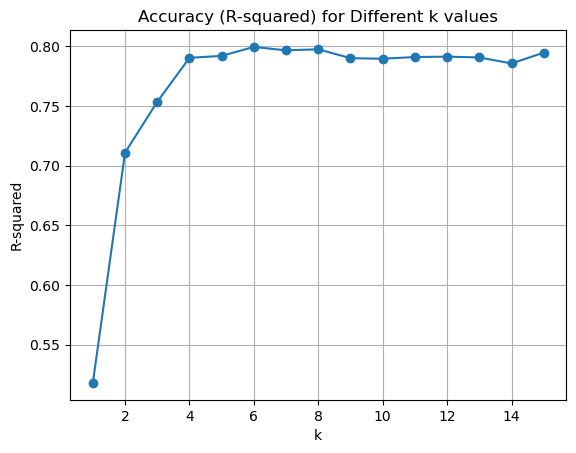

In [44]:
# 9.7: Plot accuracy for different k values
plt.plot(results_df['k'], results_df['accuracy'], marker='o')
plt.xlabel('k')
plt.ylabel('R-squared')
plt.title('Accuracy (R-squared) for Different k values')
plt.grid(True)
plt.show()

In [45]:
# 9.8: Retrain with the best k 
best_k = int(results_df.loc[results_df['accuracy'].idxmax()]['k'])  
print(f"The best k is {best_k}")

# Retraining with the best k
knn_best = KNeighborsRegressor(n_neighbors=best_k).fit(trainNorm, y_train)  

# Predictions with the best k value on the validation set
valid_pred_best = knn_best.predict(validNorm)

# Evaluate the performance on the validation set
valid_accuracy_best = r2_score(y_valid, valid_pred_best)  
print(f"Validation R2 with best k={best_k}: {valid_accuracy_best}")


The best k is 6
Validation R2 with best k=6: 0.7994387242816436


In [46]:
# 9.9: Retrain the classifier on the entire dataset with the best k
knn_best_final = KNeighborsRegressor(n_neighbors=best_k).fit(trainNorm, y_train)  

# Final Evaluation of kNN model
print(f"Final Evaluation with k={best_k} on the training set:")
train_pred_final = knn_best_final.predict(trainNorm)
train_r2_final = r2_score(y_train, train_pred_final)  
train_mae_final = mean_absolute_error(y_train, train_pred_final)  
print(f"Training R2: {train_r2_final}")
print(f"Training MAE: {train_mae_final}")


Final Evaluation with k=6 on the training set:
Training R2: 0.8452235037847169
Training MAE: 0.9269444444444446


In [47]:
# Initialize and train Decision Tree
tree_model = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [48]:
# Predict and evaluate on the validation set
y_pred_tree_valid = tree_model.predict(X_valid)
tree_mae_valid = mean_absolute_error(y_valid, y_pred_tree_valid)
tree_r2_valid = r2_score(y_valid, y_pred_tree_valid)

print(f"Decision Tree MAE (Validation): {tree_mae_valid}")
print(f"Decision Tree R² (Validation): {tree_r2_valid}")


Decision Tree MAE (Validation): 0.732430288747843
Decision Tree R² (Validation): 0.9149015626270943


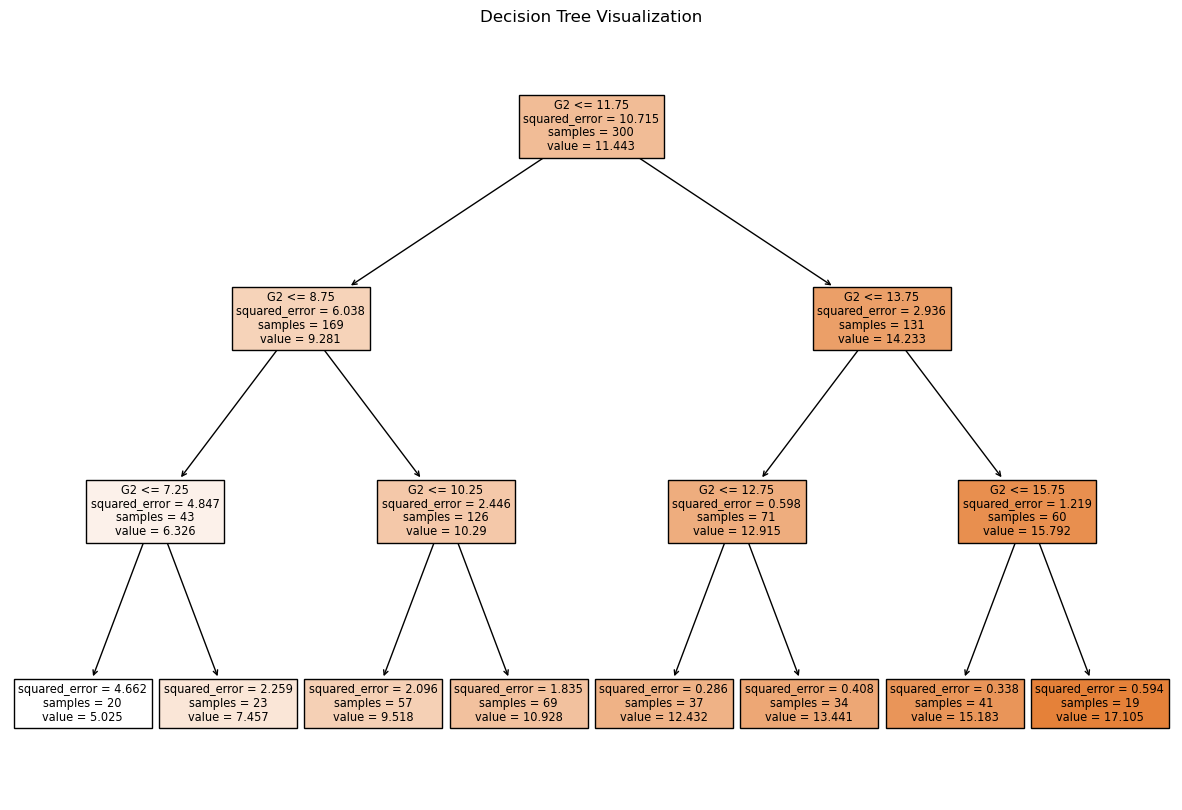

In [49]:
plt.figure(figsize=(15, 10))
plot_tree(tree_model, feature_names=predictors, filled=True)
plt.title("Decision Tree Visualization")
plt.show()

In [50]:
# Regression Tree (Decision Tree Regressor for continuous G3)
reg_tree = DecisionTreeRegressor(random_state=0)
reg_tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [51]:
# Predictions for Regression Tree (Train and Validation)
reg_tree_train_pred = reg_tree.predict(X_train)
reg_tree_valid_pred = reg_tree.predict(X_valid)

In [52]:
# Regression Tree Evaluation (R-squared and MAE)
train_r2_regtree = r2_score(y_train, reg_tree_train_pred)
valid_r2_regtree = r2_score(y_valid, reg_tree_valid_pred)
train_mae_regtree = mean_absolute_error(y_train, reg_tree_train_pred)
valid_mae_regtree = mean_absolute_error(y_valid, reg_tree_valid_pred)


In [53]:
# Displaying Regression Tree performance metrics
print(f'Regression Tree Training R2: {train_r2_regtree}')
print(f'Regression Tree Validation R2: {valid_r2_regtree}')
print(f'Regression Tree Training MAE: {train_mae_regtree}')
print(f'Regression Tree Validation MAE: {valid_mae_regtree}')

Regression Tree Training R2: 0.9998444565883523
Regression Tree Validation R2: 0.7715336057530354
Regression Tree Training MAE: 0.0033333333333333335
Regression Tree Validation MAE: 1.0986842105263157


In [54]:
# Model Comparison for Decision Tree and Regression Tree
print(f'Decision Tree Validation R2: {valid_r2}')
print(f'Decision Tree Validation MAE: {valid_mae}')
print(f'Regression Tree Validation R2: {valid_r2_regtree}')
print(f'Regression Tree Validation MAE: {valid_mae_regtree}')

Decision Tree Validation R2: 0.9173285716138717
Decision Tree Validation MAE: 0.7322267676949804
Regression Tree Validation R2: 0.7715336057530354
Regression Tree Validation MAE: 1.0986842105263157


In [55]:
# 14. Logistic Regression
d3_cleaned['age'] = d3_cleaned['age'].astype('category')
d3_cleaned['Passed'] = (d3_cleaned['G3'] >= 10).astype(int)

/var/folders/9s/szzjlq6j5sv3fq1krv3r8sc80000gn/T/ipykernel_8576/2153085342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3_cleaned['age'] = d3_cleaned['age'].astype('category')
/var/folders/9s/szzjlq6j5sv3fq1krv3r8sc80000gn/T/ipykernel_8576/2153085342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3_cleaned['Passed'] = (d3_cleaned['G3'] >= 10).astype(int)


In [56]:
X_logit = d3_cleaned[['G1', 'G2', 'Dalc', 'Walc', 'studytime', 'Medu', 'Fedu', 'age']]
y_logit = d3_cleaned['Passed']

In [57]:
logit_model = LogisticRegression(solver='liblinear', penalty='l2')
logit_model.fit(X_logit, y_logit)

LogisticRegression(solver='liblinear')

In [58]:
# Print coefficients and intercept
print('Intercept:', logit_model.intercept_)
print(pd.DataFrame({'coeff': logit_model.coef_[0]}, index=X_logit.columns).transpose())

Intercept: [-1.34533013]
            G1        G2      Dalc      Walc  studytime      Medu      Fedu  \
coeff  0.26224  1.359828 -0.230362  0.464256  -0.414468 -0.145283 -0.131198   

            age  
coeff -0.797766  


In [59]:
# Predictions and Evaluation
logit_pred = logit_model.predict(X_logit)
classificationSummary(y_logit, logit_pred)

Confusion Matrix (Accuracy 0.9043)

       Prediction
Actual   0   1
     0  72  25
     1  11 268


In [60]:
# Prediction probabilities
logit_proba = logit_model.predict_proba(X_logit)
logit_result = pd.DataFrame({'actual': y_logit, 'p(0)': logit_proba[:,0], 'p(1)': logit_proba[:,1], 'predicted': logit_pred})


In [61]:
# Display the confusion matrix and classification summary
classificationSummary(y_logit, logit_pred)

Confusion Matrix (Accuracy 0.9043)

       Prediction
Actual   0   1
     0  72  25
     1  11 268


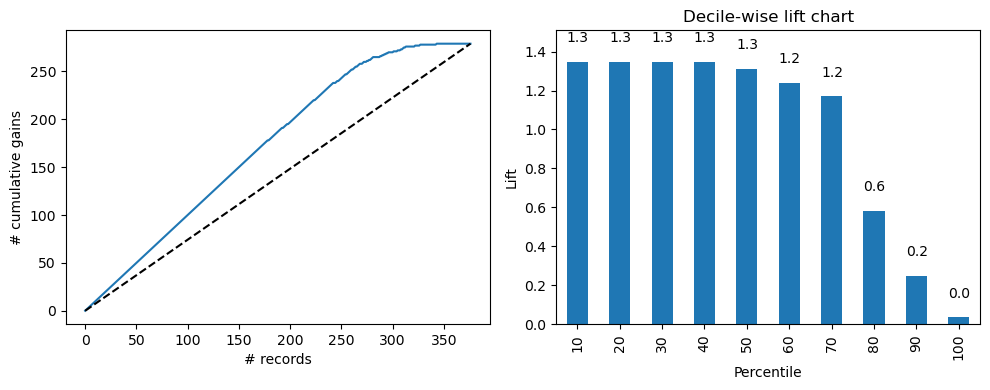

In [62]:
# Gains and Lift Charts
df = logit_result.sort_values(by='p(1)', ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df['actual'], ax=axes[0])
liftChart(df['actual'], title='Decile-wise lift chart', ax=axes[1])

plt.tight_layout()
plt.show()

In [63]:
# Step 6: Normalize Features for Clustering

# Select numerical columns for clustering (can also include more or different columns)
numeric_columns = d3_cleaned.select_dtypes(include=[np.number]).columns.tolist()

# Normalize the features for clustering
scaler = StandardScaler()
d3_cleaned_norm = pd.DataFrame(scaler.fit_transform(d3_cleaned[numeric_columns]), 
                                 columns=numeric_columns)

# Display the normalized data
d3_cleaned_norm.head()


,Medu,Fedu,Dalc,Walc,studytime,G1,G2,G3,Total_Alcohol,Passed
0,1.111371,1.328644,-0.536642,-1.005396,-0.047262,-3.409335,-1.052793,-0.895750,-0.892020,-1.695962
1,-1.649920,-1.416247,-0.536642,-1.005396,-0.047262,-1.701387,-1.230224,-0.895750,-0.892020,-1.695962
2,-1.649920,-1.416247,0.587466,0.553486,-0.047262,-0.752527,-0.343066,-0.139911,0.622199,0.589636
3,1.111371,-0.501283,-0.536642,-1.005396,1.137432,1.145193,0.898956,0.918264,-0.892020,0.589636
4,0.190940,0.413680,-0.536642,-0.225955,-0.047262,-1.132071,0.011797,0.011257,-0.387280,0.589636


In [64]:
# Step 7: Apply K-Means Clustering

from sklearn.cluster import KMeans

# Apply K-Means clustering with 3 clusters (can be adjusted)
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(d3_cleaned_norm)

# Get cluster membership (labels)
d3_cleaned['Cluster_KMeans'] = kmeans.labels_

# Display the cluster centers (means of features in each cluster)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=numeric_columns)
print("Cluster Centers (Means):\n", centroids)

# Display the membership
print("Cluster Memberships:\n", d3_cleaned[['Cluster_KMeans']].head())



/Applications/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster Centers (Means):
        Medu      Fedu      Dalc      Walc  studytime        G1        G2  \
0 -0.390384 -0.366447 -0.163912 -0.180829  -0.159496 -1.044177 -1.155516   
1  0.169129  0.140492 -0.430092 -0.364481   0.211013  0.550694  0.576888   
2  0.020003  0.073837  1.518870  1.344062  -0.419594 -0.242853 -0.170704   

         G3  Total_Alcohol    Passed  
0 -1.229910      -0.190697 -1.551609  
1  0.586555      -0.429142  0.589636  
2 -0.098879       1.552362  0.328424  
Cluster Memberships:
    Cluster_KMeans
0               0
1               0
2               2
3               1
4               1


/var/folders/9s/szzjlq6j5sv3fq1krv3r8sc80000gn/T/ipykernel_8576/2382030051.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3_cleaned['Cluster_KMeans'] = kmeans.labels_


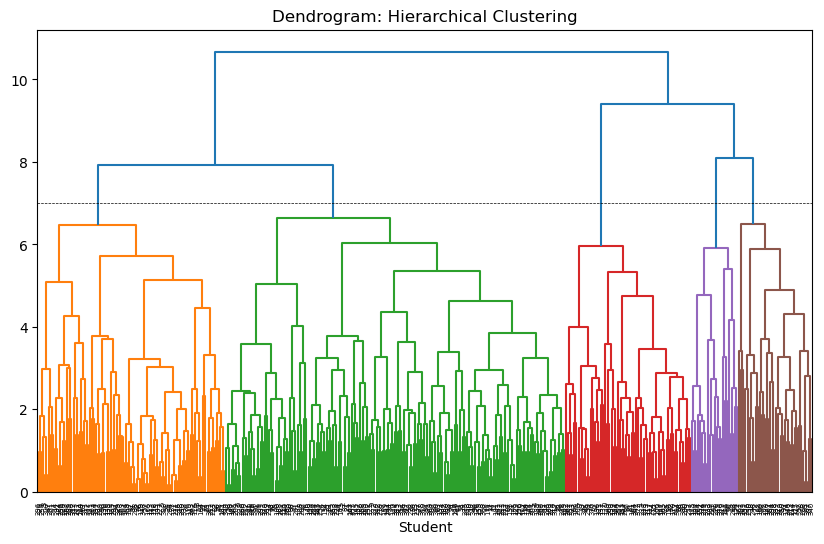

In [65]:
# Step 8: Perform Hierarchical Clustering

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Perform hierarchical clustering using 'complete' linkage and 'euclidean' metric
Z = linkage(d3_cleaned_norm, method='complete', metric='euclidean')

# Create a dendrogram to visualize the hierarchical clustering
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=d3_cleaned.index, color_threshold=7)
plt.axhline(y=7, color='black', linewidth=0.5, linestyle='dashed')
plt.title("Dendrogram: Hierarchical Clustering")
plt.xlabel("Student")
plt.show()



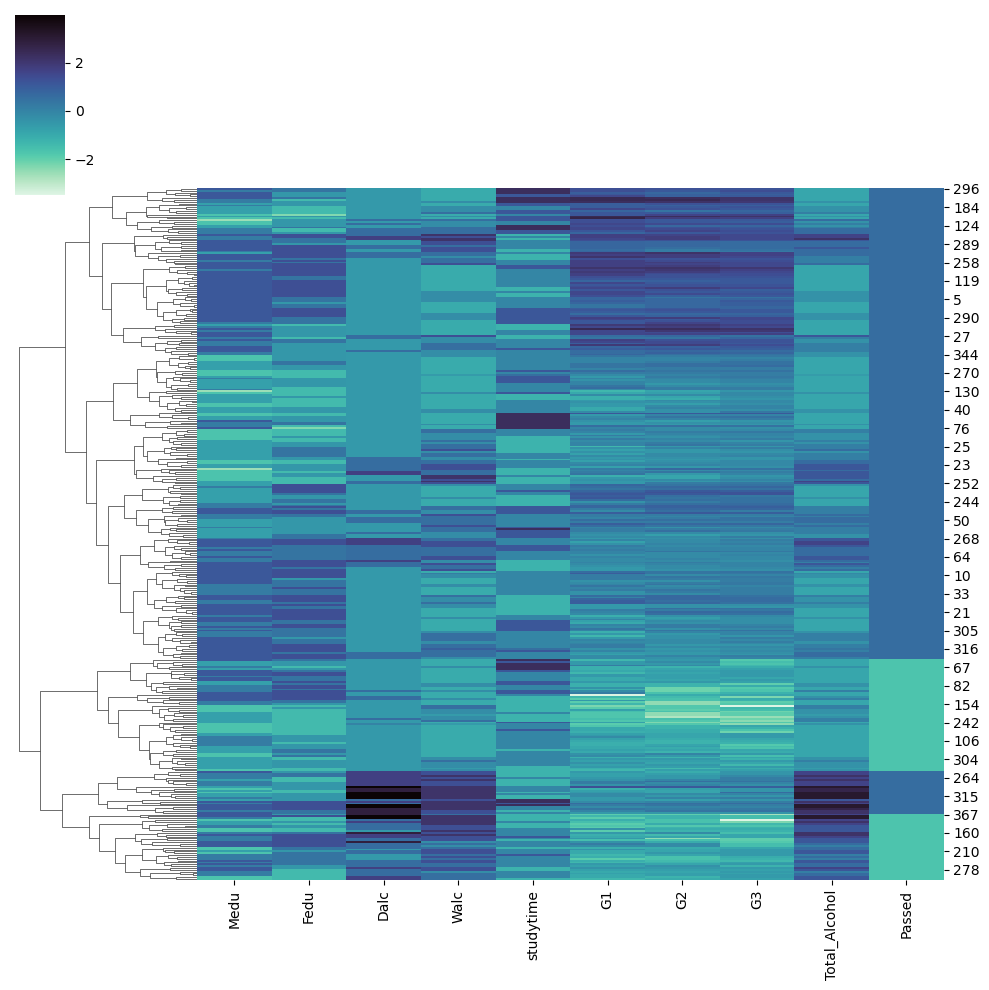

In [66]:
#Cluster map (aka Heat map)
sns.clustermap(d3_cleaned_norm, method='complete', col_cluster=False,  cmap="mako_r") #mako_r is a commonly used color palette for Heatmaps. 'rocket' is another common one
plt.show()

In [67]:
# Perform hierarchical clustering using 'complete' linkage and 'euclidean' metric
Z = linkage(d3_cleaned_norm, method='complete', metric='euclidean')

# Assign clusters based on a maximum number of clusters (e.g., 3 clusters from hierarchical clustering)
d3_cleaned['Cluster_Hierarchical'] = fcluster(Z, 3, criterion='maxclust')

/var/folders/9s/szzjlq6j5sv3fq1krv3r8sc80000gn/T/ipykernel_8576/1172425211.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3_cleaned['Cluster_Hierarchical'] = fcluster(Z, 3, criterion='maxclust')


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

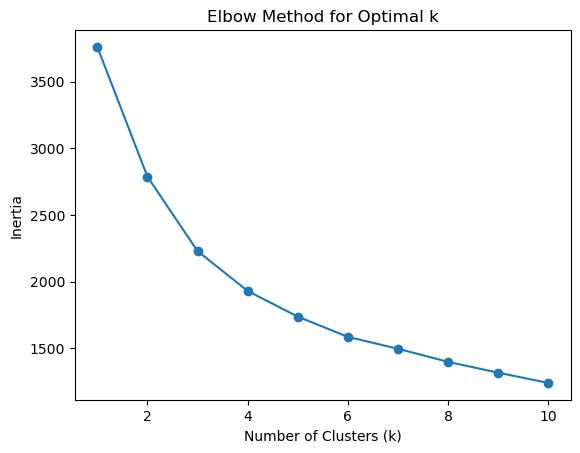

The best k is: 3


/Applications/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/9s/szzjlq6j5sv3fq1krv3r8sc80000gn/T/ipykernel_8576/1448073690.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d3_cleaned['Cluster_KMeans_Best'] = kmeans_best.labels_


In [68]:
# Step 9: Elbow Method to Find Optimal Number of Clusters

inertia = []
for n_clusters in range(1, 11):  # Test for clusters from 1 to 10
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(d3_cleaned_norm)
    inertia.append(kmeans.inertia_)

# Plot the inertia values to observe the "elbow"
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

# From the plot, determine the best k and fit the final KMeans model (e.g., k=3)
best_k = 3  # Assume 3 clusters based on the elbow method
kmeans_best = KMeans(n_clusters=best_k, random_state=0)
kmeans_best.fit(d3_cleaned_norm)

# Assign cluster labels based on the final k-means model
d3_cleaned['Cluster_KMeans_Best'] = kmeans_best.labels_

print(f"The best k is: {best_k}")

Cluster Means (KMeans):
                          Medu      Fedu      Dalc      Walc  studytime  \
Cluster_KMeans_Best                                                      
0                    2.368421  2.147368  1.331579  2.057895   1.905263   
1                    2.976303  2.701422  1.094787  1.822275   2.218009   
2                    2.814286  2.628571  2.828571  4.014286   1.685714   

                            G1         G2         G3  Total_Alcohol    Passed  \
Cluster_KMeans_Best                                                             
0                     8.731579   8.210526   7.394737       3.389474  0.063158   
1                    12.933649  13.092417  13.402844       2.917062  1.000000   
2                    10.842857  10.985714  11.135714       6.842857  0.885714   

                     Cluster_KMeans  Cluster_Hierarchical  Cluster_KMeans_Best  
Cluster_KMeans_Best                                                             
0                               0.0 

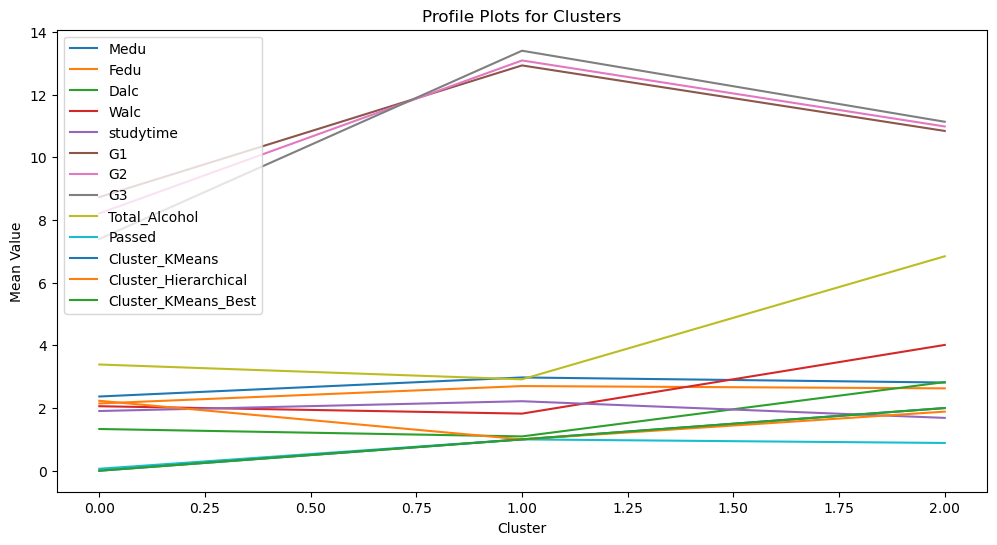

In [69]:
# Step 10: Profile Plots for Each Cluster

# Select only numeric columns for mean calculation (avoid non-numeric columns)
numeric_columns = d3_cleaned.select_dtypes(include=[np.number]).columns.tolist()

# Calculate the means of the numeric columns for each cluster
clust_mean = d3_cleaned.groupby('Cluster_KMeans_Best')[numeric_columns].mean()

# Display the cluster means for numeric features
print("Cluster Means (KMeans):\n", clust_mean)

# Profile plots for each cluster (mean values of features within clusters)
plt.figure(figsize=(12, 6))
for col in clust_mean.columns:
    plt.plot(clust_mean.index, clust_mean[col], label=col)
plt.title("Profile Plots for Clusters")
plt.xlabel("Cluster")
plt.ylabel("Mean Value")
plt.legend()
plt.show()

In [70]:
# Step 11: Summarize Cluster Analysis Results

# Display cluster means for the best K-Means model
print("Cluster Means (KMeans):\n", clust_mean)

# Display the count of samples in each cluster
print("\nCluster Membership Counts:")
print(d3_cleaned['Cluster_KMeans_Best'].value_counts())

# You can also check how the hierarchical clusters compare with KMeans clusters
print("\nComparison of KMeans and Hierarchical Clusters:")
print(pd.crosstab(d3_cleaned['Cluster_KMeans_Best'], d3_cleaned['Cluster_Hierarchical']))

Cluster Means (KMeans):
                          Medu      Fedu      Dalc      Walc  studytime  \
Cluster_KMeans_Best                                                      
0                    2.368421  2.147368  1.331579  2.057895   1.905263   
1                    2.976303  2.701422  1.094787  1.822275   2.218009   
2                    2.814286  2.628571  2.828571  4.014286   1.685714   

                            G1         G2         G3  Total_Alcohol    Passed  \
Cluster_KMeans_Best                                                             
0                     8.731579   8.210526   7.394737       3.389474  0.063158   
1                    12.933649  13.092417  13.402844       2.917062  1.000000   
2                    10.842857  10.985714  11.135714       6.842857  0.885714   

                     Cluster_KMeans  Cluster_Hierarchical  Cluster_KMeans_Best  
Cluster_KMeans_Best                                                             
0                               0.0 